# MIT Deep Learning Project
## Detecting early stage Alzheimer from images

### Prathma Rastogi

## Importing Dependencies

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.flatten import Flatten
import torch.optim as optim
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

Setting up device

In [2]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Loading Dataset

#### Source : https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

In [4]:
PATH = "/content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/"

In [5]:
drive.mount('/content/drive')
!ls "{PATH}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 4Alzheimers.zip       'Module 7 Project Proposal.pdf'
'Alzheimer Dataset'    'Module 7 Project Report copy.pdf'
'Alzheimer_s Dataset'  'Module 7 Project Report.gdoc'
 Dataset.zip	        PROJECT.ipynb


In [6]:
!rm -r "/content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset"

In [7]:
unzip_path = PATH + "4Alzheimers.zip"
!unzip "{unzip_path}" -d "{PATH}"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: /content/drive/MyDrive/MIT_Deep_Learning_/Module 7 & 8/Alzheimer_s Da

## Train and Test Images Dataset

* Applying transform on images, to rescale images to 64 x 64 size
* Normalizing the images
* Turning to grayscale to convert input to have number of channels = 1
* Shuffled the loaded training data and test data to reduce overfitting and underfitting

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize((64, 64)), transforms.Grayscale(num_output_channels=1)])

train_dataset = torchvision.datasets.ImageFolder(
    root = PATH + "Alzheimer_s Dataset/train",
    transform = transform,
)
train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
)

5121 Images,

* Mild Demented: 717
* Moderate Demented: 52
* Non Demented: 2560
* Very Mild Demented: 1792

In [9]:
len(train_dataset)

5121

In [10]:
test_dataset = torchvision.datasets.ImageFolder(
    root = PATH + "Alzheimer_s Dataset/test",
    transform = transform,
)
test_loader = DataLoader(
    dataset = test_dataset,
    shuffle = True,
)

1279 images,
* Mild Demented: 179
* Moderate Demented: 12
* Non Demented: 640
* Very Mild Demented: 448

In [11]:
len(test_dataset)

1279

In [12]:
classes = {0: 'Mild Demented', 1: 'Moderate Demented', 2: 'Non Demented', 3: 'Very Mild Demented'}
num_classes = 4

## Dataset Sample Images Visualization

Sample training images

In [13]:
train_data_sample = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [14]:
#100 examples of 128x128 pixels in rgb channel (i.e. rgb channels, hence 3)
dataiter = iter(train_data_sample)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>
torch.Size([100, 1, 64, 64])
torch.Size([100])


In [15]:
labels

tensor([3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 0, 3, 3, 3, 2, 3, 3, 0, 3, 2, 3, 0,
        0, 0, 3, 2, 3, 2, 3, 2, 3, 3, 0, 2, 3, 2, 2, 3, 1, 0, 0, 2, 2, 2, 3, 2,
        2, 0, 3, 2, 2, 0, 2, 3, 0, 2, 3, 2, 0, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2,
        2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 0, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3,
        2, 2, 2, 2])

In [16]:
train_examples = enumerate(train_data_sample)
batch_idx, (training_sample_data, example_targets) = next(train_examples)

In [17]:
training_sample_data.shape

torch.Size([100, 1, 64, 64])

25 images from training dataset

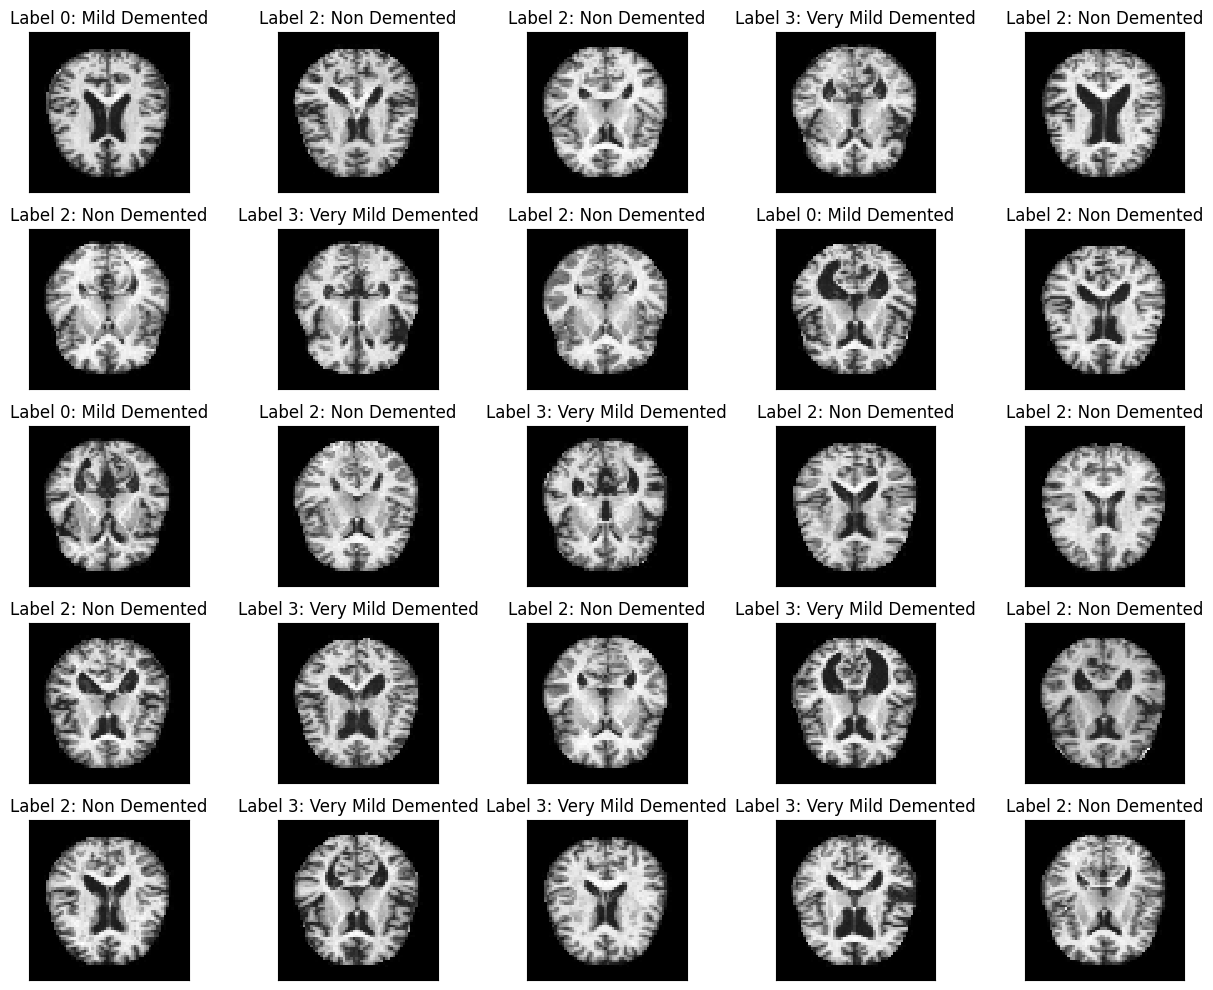

In [18]:
fig = plt.figure(figsize=(13,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(training_sample_data[i][0], cmap='gray', interpolation='none')
  class_ = classes[example_targets[i].item()]
  plt.title("Label {}: {}".format(example_targets[i], class_))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

Sample test images

In [19]:
test_data_sample = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [20]:
#100 examples of 224x224 pixels in rgb channel (i.e. rgb channels, hence 3)
dataiter = iter(test_data_sample)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([100, 1, 64, 64])
torch.Size([100])


In [21]:
test_examples = enumerate(test_data_sample)
batch_idx, (test_sample_data, example_targets) = next(test_examples)

In [22]:
test_sample_data.shape

torch.Size([100, 1, 64, 64])

25 Images from test dataset

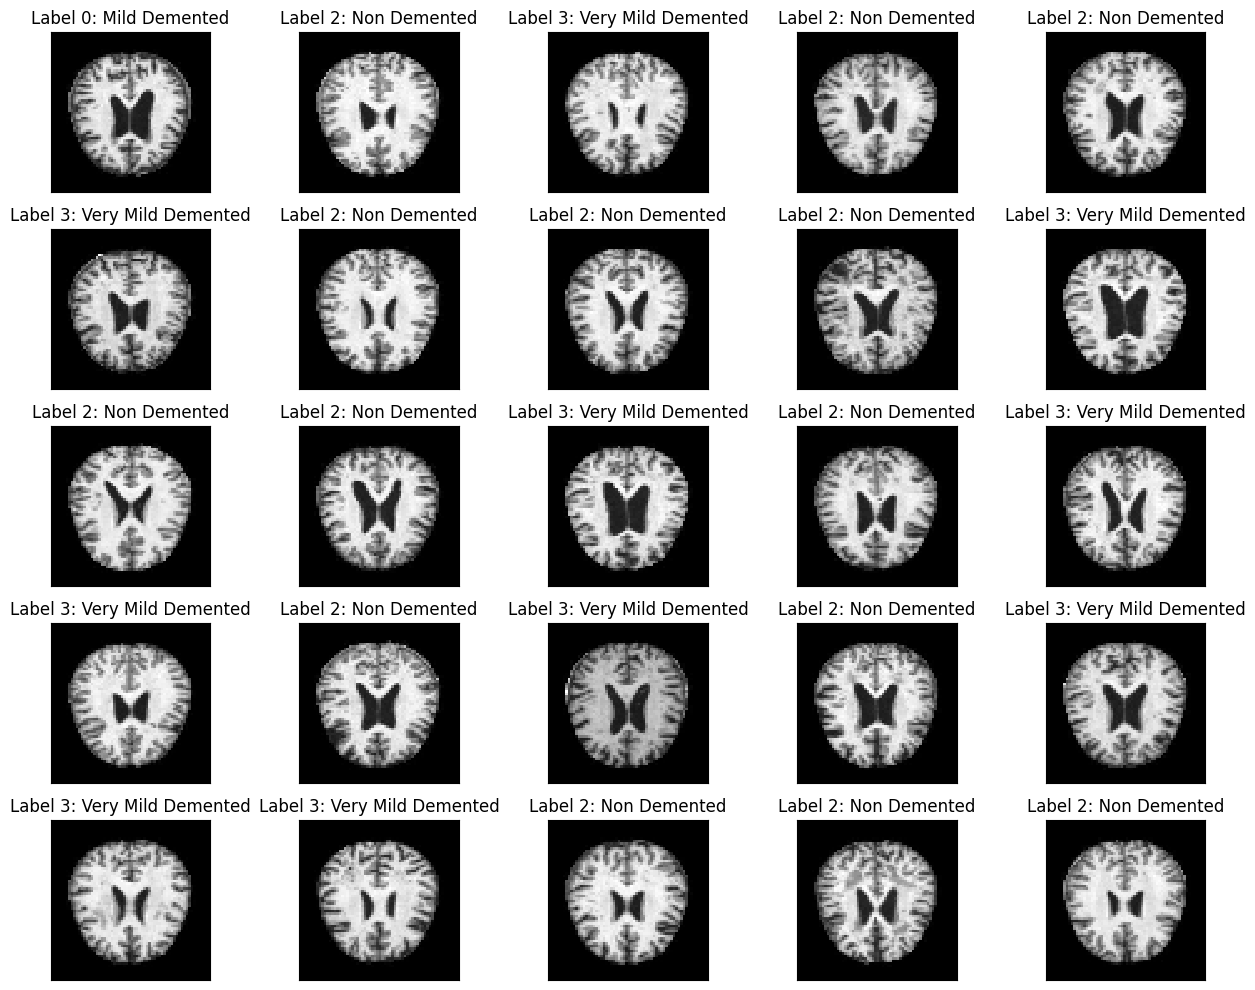

In [23]:
fig = plt.figure(figsize=(13,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(test_sample_data[i][0], cmap='gray', interpolation='none')
  class_ = classes[example_targets[i].item()]
  plt.title("Label {}: {}".format(example_targets[i], class_))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

## Train, Test and Validation Dataset Split




### Dataset Split

* 70% of images from training data folder to be training data
* 30% of images from training data folder to be validation data
* Test Dataset is test images folder


In [24]:
al_train_dataset, al_val_dataset = torch.utils.data.random_split(train_dataset, [int(np.floor(len(train_dataset)*0.70)), int(np.ceil(len(train_dataset)*0.30))])

### Dataloaders Initialization

* Batch Size 50
* Training data size = 3584
* Validation data size = 1537
* Test data size = 1279

In [25]:
# We will create DataLoaders just like before with a batch size of 100
batch_size=50
dataloaders = {'train': DataLoader(al_train_dataset, batch_size=batch_size),
               'val': DataLoader(al_val_dataset, batch_size=batch_size),
               'test': DataLoader(test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(al_train_dataset),
                 'val': len(al_val_dataset),
                 'test': len(test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 3584, 'val': 1537, 'test': 1279}


In [26]:
# It means that there are a total of 72 batches in the training dataset, with each batch containing 50 samples.
train_dataloader = dataloaders['train']
print(f'Alzhiemers train data size = {len(train_dataloader)}')

Alzhiemers train data size = 72


In [27]:
# It means that there are a total of 31 batches in the validation dataset, with each batch containing 50 samples.
val_dataloader = dataloaders['val']
print(f'Alzheimers val data size = {len(val_dataloader)}')

Alzheimers val data size = 31


In [28]:
# It means that there are a total of 26 batches in the test dataset, with each batch containing 50 samples.
test_dataloader = dataloaders['test']
print(f'Alzheimers test data size = {len(test_dataloader)}')

Alzheimers test data size = 26


## Models Initialization

### CNN Base Architecture

* Convolutional Layers (`conv1` and `conv2`):

    * `conv1`: First convolutional layer with 1 input channel (grayscale images), 16 output channels (feature maps), a kernel size of 3x3, and padding of 1. The stride is set to 1, so the output size remains the same after convolution.
    * `conv2`: The second convolutional layer has 16 input channels (from the previous layer's output), 32 output channels, a kernel size of 3x3, and padding of 1. Like the first layer, the stride is 1.

* Activation Function (`F.relu`):
    * After each convolutional layer, a Rectified Linear Unit (ReLU) activation function is applied element-wise to introduce non-linearity to the model.

* Max Pooling (`F.max_pool2d`):

    * After each activation layer, a max pooling operation is applied with a kernel size of 2x2 and a stride of 2. This operation reduces the spatial dimensions of the feature maps by half, helping to reduce computation and control overfitting.

* Fully Connected Layers (`fc1 and fc2`):

    * `fc1`: After the convolutional layers and pooling operations, the feature maps are flattened into a 1D tensor using x.view. This tensor is then passed through the first fully connected (linear) layer with 32 * 16 * 16 input features and 128 output features.
    * `fc2`: The output of fc1 is passed through another fully connected layer with 128 input features and the number of output features equal to the number of classes you want to classify (denoted as num_classes).

* Output:
    * The output of fc2 is the final result, which is a set of scores corresponding to each class. These scores are then often passed through a softmax function to convert them into class probabilities.

### CNN with Dropout

* A dropout layer added to prevent overfitting. It works by "dropping out" a certain fraction of neurons during training to not to contribute in the forward or backward passes, effectively reducing the capacity of the network.

* In PyTorch, you can use the `nn.Dropout` module to add dropout layers to your CNN architecture.

### 2 Layers CNN without Dropout


In [43]:
class TwoLayerCNN(nn.Module):
    def __init__(self):
        super(TwoLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 16 * 16)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
cnn2layer_model = TwoLayerCNN().to(device)
print(cnn2layer_model)

TwoLayerCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


### 2 Layers CNN with Dropout


In [45]:
class TwoLayerCNNWithDropout(nn.Module):
    def __init__(self):
        super(TwoLayerCNNWithDropout, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # First fully connected layer
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        # Second fully connected layer
        self.fc2 = nn.Linear(128, num_classes)
        # Dropout to reduce overfitting with probability of 0.5
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 16 * 16)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

In [46]:
cnn2layer_dropout_model = TwoLayerCNNWithDropout().to(device)
print(cnn2layer_dropout_model)

TwoLayerCNNWithDropout(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### 3 Layers CNN without Dropout

In [83]:
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # First fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # Second fully connected layer (output layer)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply the first convolutional layer, followed by ReLU activation and max pooling
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Apply the second convolutional layer, followed by ReLU activation and max pooling
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Apply the third convolutional layer, followed by ReLU activation and max pooling
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 64 * 8 * 8) #For example, if the output shape of the last conv layer is (batch_size, 64, 8, 8)
        # Apply the first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Apply the second fully connected layer (output layer)
        x = self.fc2(x)
        return x

In [84]:
cnn3layer_model = ThreeLayerCNN().to(device)
print(cnn3layer_model)

ThreeLayerCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


### 3 Layers CNN with Dropout

In [92]:
class ThreeLayerCNNWithDropout(nn.Module):
    def __init__(self):
        super(ThreeLayerCNNWithDropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=0.5)  # Adjust the dropout probability as needed

        self.fc1 = nn.Linear(64* 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor

        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [93]:
cnn3layer_dropout_model = ThreeLayerCNNWithDropout().to(device)
print(cnn3layer_dropout_model)

ThreeLayerCNNWithDropout(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


### VGG16

* VGG16 refers to the VGG model, also called VGGNet. It is a convolution neural network (CNN) model supporting 16 layers.

* VGG16 replaces the large filters with sequences of smaller 3x3 filters. The kernel size is 11 for the first convolutional layer and 5 for the second layer. The researchers trained the VGG model for several weeks using NVIDIA Titan Black GPUs.

* VGG uses a smaller convolutional filter, which reduces the network's tendency to over-fit during training exercises.



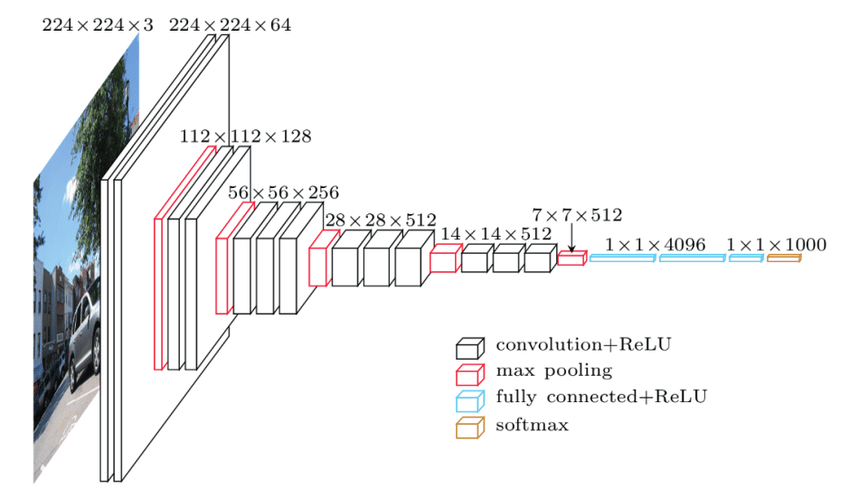

In [147]:
vgg16_model = models.vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, num_classes)
print(vgg16_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Training Models

In [53]:
phases = ['train', 'val', 'test']

In [153]:
def train_model(model_name, model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0
    all_inputs = []
    all_predictions = []
    all_outputs = []

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            epoch_inputs = []
            epoch_predictions = []
            epoch_outputs = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                assert inputs.size(0) == labels.size(0)
                inputs = inputs.to(device)
                labels = labels.to(device)

                if (model_name == 'VGG16'):
                  inputs = inputs.repeat(1, 3, 1, 1)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

                epoch_inputs.extend(inputs)
                epoch_predictions.extend(predictions.tolist())
                epoch_outputs.extend(labels.tolist())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            all_inputs.append(epoch_inputs)
            all_predictions.append(epoch_predictions)
            all_outputs.append(epoch_outputs)
        torch.cuda.empty_cache()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves, all_inputs, all_predictions, all_outputs, best_epoch

### 2 Layers CNN without Dropout Training

**~96%** accuracy on epoch 19

In [59]:
num_epochs = 25
learning_rate = 0.001

In [60]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

cnn2layer_model, cnn2layer_training_curves, cnn2layer_all_inputs, cnn2layer_predicted_outputs, cnn2layer_actual_outputs, cnn2layer_best_epoch = train_model('CNN 2 Layers', cnn2layer_model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs)


Epoch 1/25
----------
train Loss: 0.6707 Acc: 0.7224
val   Loss: 0.6406 Acc: 0.7365
test  Loss: 0.8683 Acc: 0.6122

Epoch 2/25
----------
train Loss: 0.4890 Acc: 0.8170
val   Loss: 0.5491 Acc: 0.7580
test  Loss: 0.9672 Acc: 0.5794

Epoch 3/25
----------
train Loss: 0.3327 Acc: 0.8929
val   Loss: 0.4192 Acc: 0.8484
test  Loss: 0.9194 Acc: 0.6271

Epoch 4/25
----------
train Loss: 0.2312 Acc: 0.9325
val   Loss: 0.3623 Acc: 0.8562
test  Loss: 1.1070 Acc: 0.6059

Epoch 5/25
----------
train Loss: 0.1538 Acc: 0.9621
val   Loss: 0.3451 Acc: 0.8647
test  Loss: 1.2550 Acc: 0.5989

Epoch 6/25
----------
train Loss: 0.1879 Acc: 0.9400
val   Loss: 0.2887 Acc: 0.8959
test  Loss: 1.0208 Acc: 0.6263

Epoch 7/25
----------
train Loss: 0.0864 Acc: 0.9824
val   Loss: 0.2270 Acc: 0.9226
test  Loss: 1.0875 Acc: 0.6411

Epoch 8/25
----------
train Loss: 0.0543 Acc: 0.9950
val   Loss: 0.2180 Acc: 0.9213
test  Loss: 1.1290 Acc: 0.6450

Epoch 9/25
----------
train Loss: 0.0379 Acc: 0.9980
val   Loss: 0.2178

### 2 Layers CNN with Dropout Training

**~95%** accuracy on epoch 24

In [63]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2layer_dropout_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

cnn2layer_dropout__model, cnn2layer_dropout_training_curves, cnn2layer_dropout_all_inputs, cnn2layer_dropout_predicted_outputs, cnn2layer_dropout_actual_outputs, cnn2layer_dropout_best_epoch = train_model('CNN 2 Layers with Dropout', cnn2layer_dropout_model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/25
----------
train Loss: 1.0289 Acc: 0.5089
val   Loss: 0.9342 Acc: 0.5211
test  Loss: 0.9791 Acc: 0.5176

Epoch 2/25
----------
train Loss: 0.9063 Acc: 0.5748
val   Loss: 0.8860 Acc: 0.5543
test  Loss: 0.9532 Acc: 0.5348

Epoch 3/25
----------
train Loss: 0.8363 Acc: 0.6085
val   Loss: 0.8177 Acc: 0.6044
test  Loss: 0.8990 Acc: 0.5794

Epoch 4/25
----------
train Loss: 0.7659 Acc: 0.6529
val   Loss: 0.7402 Acc: 0.6565
test  Loss: 0.8989 Acc: 0.6013

Epoch 5/25
----------
train Loss: 0.6674 Acc: 0.7107
val   Loss: 0.6436 Acc: 0.7137
test  Loss: 0.9254 Acc: 0.5958

Epoch 6/25
----------
train Loss: 0.5806 Acc: 0.7570
val   Loss: 0.5647 Acc: 0.7567
test  Loss: 0.9220 Acc: 0.5942

Epoch 7/25
----------
train Loss: 0.4943 Acc: 0.8019
val   Loss: 0.5010 Acc: 0.7977
test  Loss: 0.9556 Acc: 0.5950

Epoch 8/25
----------
train Loss: 0.4097 Acc: 0.8412
val   Loss: 0.4210 Acc: 0.8432
test  Loss: 1.0342 Acc: 0.5700

Epoch 9/25
----------
train Loss: 0.3454 Acc: 0.8697
val   Loss: 0.4266

### 3 Layers CNN Training

**~95.5%** accuracy on epoch 21

In [94]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

cnn3layer_model, cnn3layer_training_curves, cnn3layer_all_inputs, cnn3layer_predicted_outputs, cnn3layer_actual_outputs, cnn3layer_best_epoch = train_model('CNN 3 Layers', cnn3layer_model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs)


Epoch 1/25
----------
train Loss: 1.0097 Acc: 0.5120
val   Loss: 0.9962 Acc: 0.5107
test  Loss: 1.0547 Acc: 0.5129

Epoch 2/25
----------
train Loss: 0.9171 Acc: 0.5625
val   Loss: 0.9504 Acc: 0.5322
test  Loss: 1.0671 Acc: 0.5152

Epoch 3/25
----------
train Loss: 0.8787 Acc: 0.5907
val   Loss: 0.9092 Acc: 0.5608
test  Loss: 1.0355 Acc: 0.5207

Epoch 4/25
----------
train Loss: 0.8455 Acc: 0.6083
val   Loss: 0.8838 Acc: 0.5699
test  Loss: 0.9939 Acc: 0.5254

Epoch 5/25
----------
train Loss: 0.7961 Acc: 0.6440
val   Loss: 0.8232 Acc: 0.6109
test  Loss: 0.9617 Acc: 0.5489

Epoch 6/25
----------
train Loss: 0.7158 Acc: 0.6950
val   Loss: 0.7083 Acc: 0.6897
test  Loss: 0.8619 Acc: 0.5958

Epoch 7/25
----------
train Loss: 0.6122 Acc: 0.7489
val   Loss: 0.6302 Acc: 0.7319
test  Loss: 0.8451 Acc: 0.5966

Epoch 8/25
----------
train Loss: 0.5137 Acc: 0.7997
val   Loss: 0.5539 Acc: 0.7710
test  Loss: 0.8883 Acc: 0.6059

Epoch 9/25
----------
train Loss: 0.4202 Acc: 0.8393
val   Loss: 0.4860

### 3 Layers CNN with Dropout Training

**~93.4%** accuracy on epoch 23

In [99]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3layer_dropout_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

cnn3layer_dropout_model, cnn3layer_dropout_training_curves, cnn3layer_dropout_all_inputs, cnn3layer_dropout_predicted_outputs, cnn3layer_dropout_actual_outputs, cnn3layer_dropout_best_epoch = train_model('CNN 3 Layers with Dropout', cnn3layer_dropout_model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs)


Epoch 1/25
----------
train Loss: 1.0605 Acc: 0.4824
val   Loss: 0.9904 Acc: 0.5127
test  Loss: 0.9906 Acc: 0.5090

Epoch 2/25
----------
train Loss: 0.9578 Acc: 0.5458
val   Loss: 0.9523 Acc: 0.5146
test  Loss: 0.9872 Acc: 0.5121

Epoch 3/25
----------
train Loss: 0.9138 Acc: 0.5709
val   Loss: 0.8929 Acc: 0.5485
test  Loss: 0.9349 Acc: 0.5332

Epoch 4/25
----------
train Loss: 0.8915 Acc: 0.5809
val   Loss: 0.8774 Acc: 0.5543
test  Loss: 0.9178 Acc: 0.5426

Epoch 5/25
----------
train Loss: 0.8580 Acc: 0.5991
val   Loss: 0.8453 Acc: 0.5849
test  Loss: 0.8906 Acc: 0.5661

Epoch 6/25
----------
train Loss: 0.8292 Acc: 0.6150
val   Loss: 0.8169 Acc: 0.6077
test  Loss: 0.8727 Acc: 0.5989

Epoch 7/25
----------
train Loss: 0.7863 Acc: 0.6367
val   Loss: 0.7786 Acc: 0.6291
test  Loss: 0.8668 Acc: 0.6083

Epoch 8/25
----------
train Loss: 0.7284 Acc: 0.6688
val   Loss: 0.7350 Acc: 0.6623
test  Loss: 0.8545 Acc: 0.6013

Epoch 9/25
----------
train Loss: 0.6709 Acc: 0.6964
val   Loss: 0.6887

### VGG16 Training

**~87%** accuracy on epoch 22

In [155]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)
vgg16_model, vgg16_training_curves, vgg16_all_inputs, vgg16_predicted_outputs, vgg16_actual_outputs, vgg16_best_epoch = train_model('VGG16', vgg16_model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs)


Epoch 1/25
----------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train Loss: 0.7128 Acc: 0.6900
val   Loss: 0.7460 Acc: 0.6760
test  Loss: 0.9617 Acc: 0.5841

Epoch 2/25
----------
train Loss: 0.6693 Acc: 0.7171
val   Loss: 0.7765 Acc: 0.6584
test  Loss: 1.0644 Acc: 0.5715

Epoch 3/25
----------
train Loss: 0.6618 Acc: 0.7154
val   Loss: 0.7238 Acc: 0.6890
test  Loss: 0.9686 Acc: 0.5864

Epoch 4/25
----------
train Loss: 0.6162 Acc: 0.7425
val   Loss: 0.6884 Acc: 0.7046
test  Loss: 1.0076 Acc: 0.5903

Epoch 5/25
----------
train Loss: 0.6018 Acc: 0.7559
val   Loss: 0.7842 Acc: 0.6695
test  Loss: 1.1380 Acc: 0.5817

Epoch 6/25
----------
train Loss: 0.5893 Acc: 0.7595
val   Loss: 0.6561 Acc: 0.7261
test  Loss: 1.0449 Acc: 0.5911

Epoch 7/25
----------
train Loss: 0.5415 Acc: 0.7863
val   Loss: 0.8017 Acc: 0.6688
test  Loss: 1.1610 Acc: 0.5848

Epoch 8/25
----------
train Loss: 0.5432 Acc: 0.7877
val   Loss: 0.6802 Acc: 0.7280
test  Loss: 1.1433 Acc: 0.6013

Epoch 9/25
----------
train Loss: 0.5046 Acc: 0.7988
val   Loss: 0.6320 Acc: 0.7398
test  Loss

## Models Performance Visualization

### Predicted Output Visualization

In [61]:
def showPredictedOutputs(best_epoch, inputs, predicted_outputs, actual_outputs):
    inputSet = inputs[best_epoch]
    actualLabelsSet = actual_outputs[best_epoch]
    predictionsSet = predicted_outputs[best_epoch]

    plt.figure(figsize=(18, 18))
    for n in range(0, 20):
        ax = plt.subplot(4, 5, n + 1)
        image = inputSet[n].cpu().numpy().transpose(1, 2, 0)  # Convert tensor to NumPy array
        image = np.clip(image, 0, 1)  # Ensure pixel values are within [0, 1]
        plt.imshow(image)
        actual_label = classes[actualLabelsSet[n]]
        predicted_label = classes[predictionsSet[n]]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### 2 Layers CNN without Dropout -- Predicted Output Samples

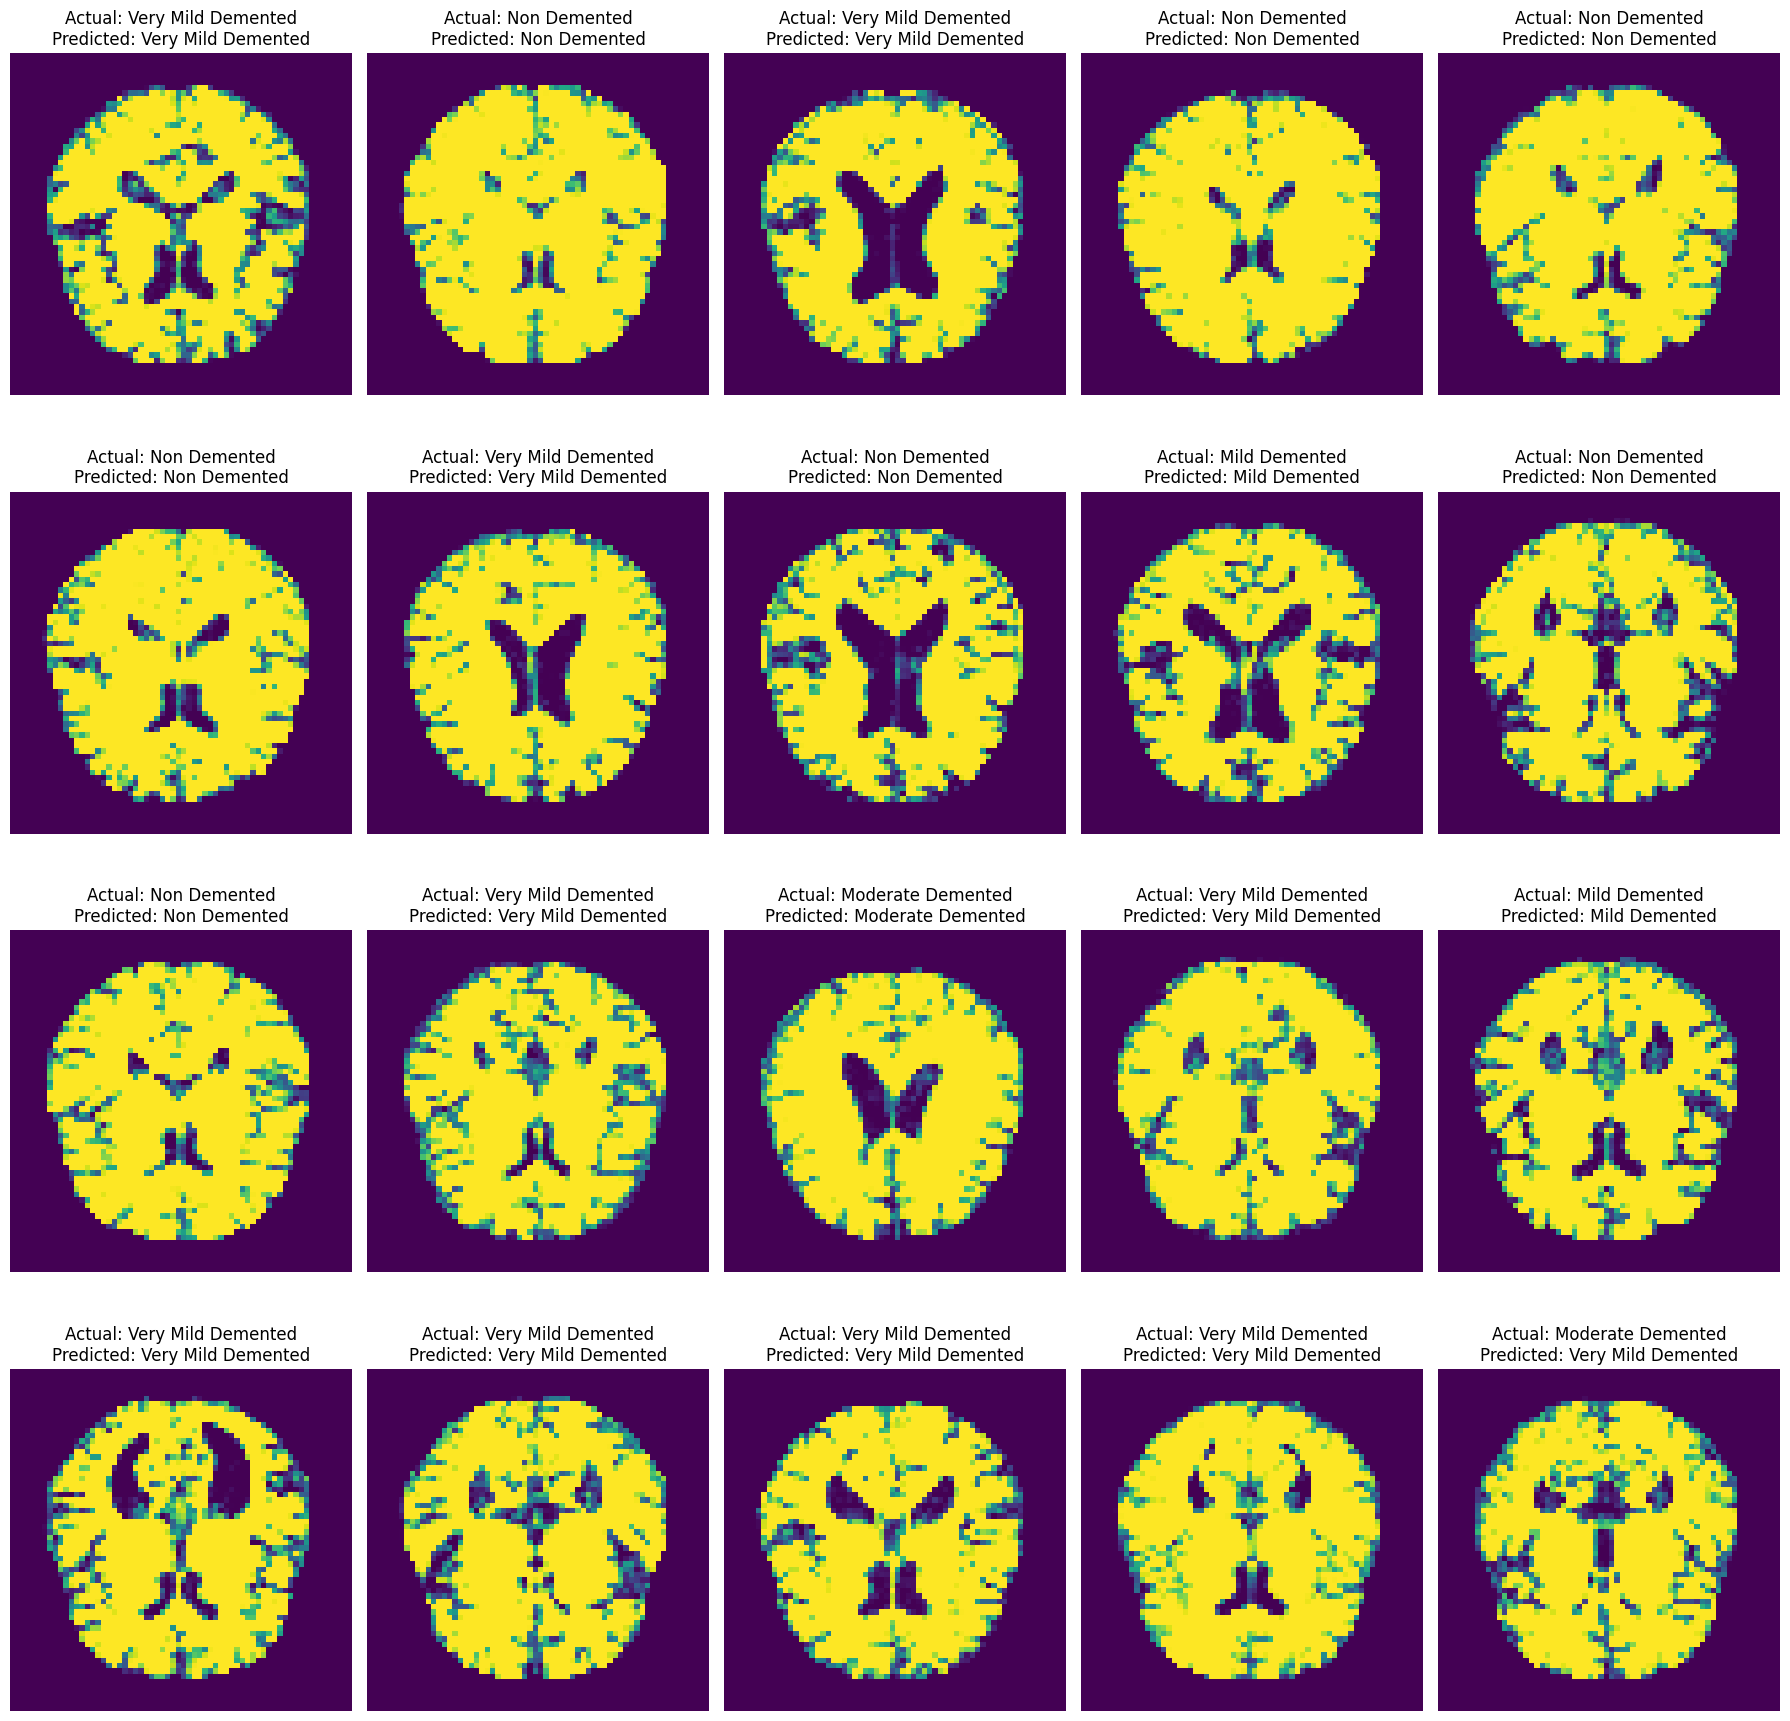

In [62]:
showPredictedOutputs(cnn2layer_best_epoch, cnn2layer_all_inputs, cnn2layer_predicted_outputs, cnn2layer_actual_outputs)

#### 2 Layers CNN with Dropout -- Predicted Output Samples

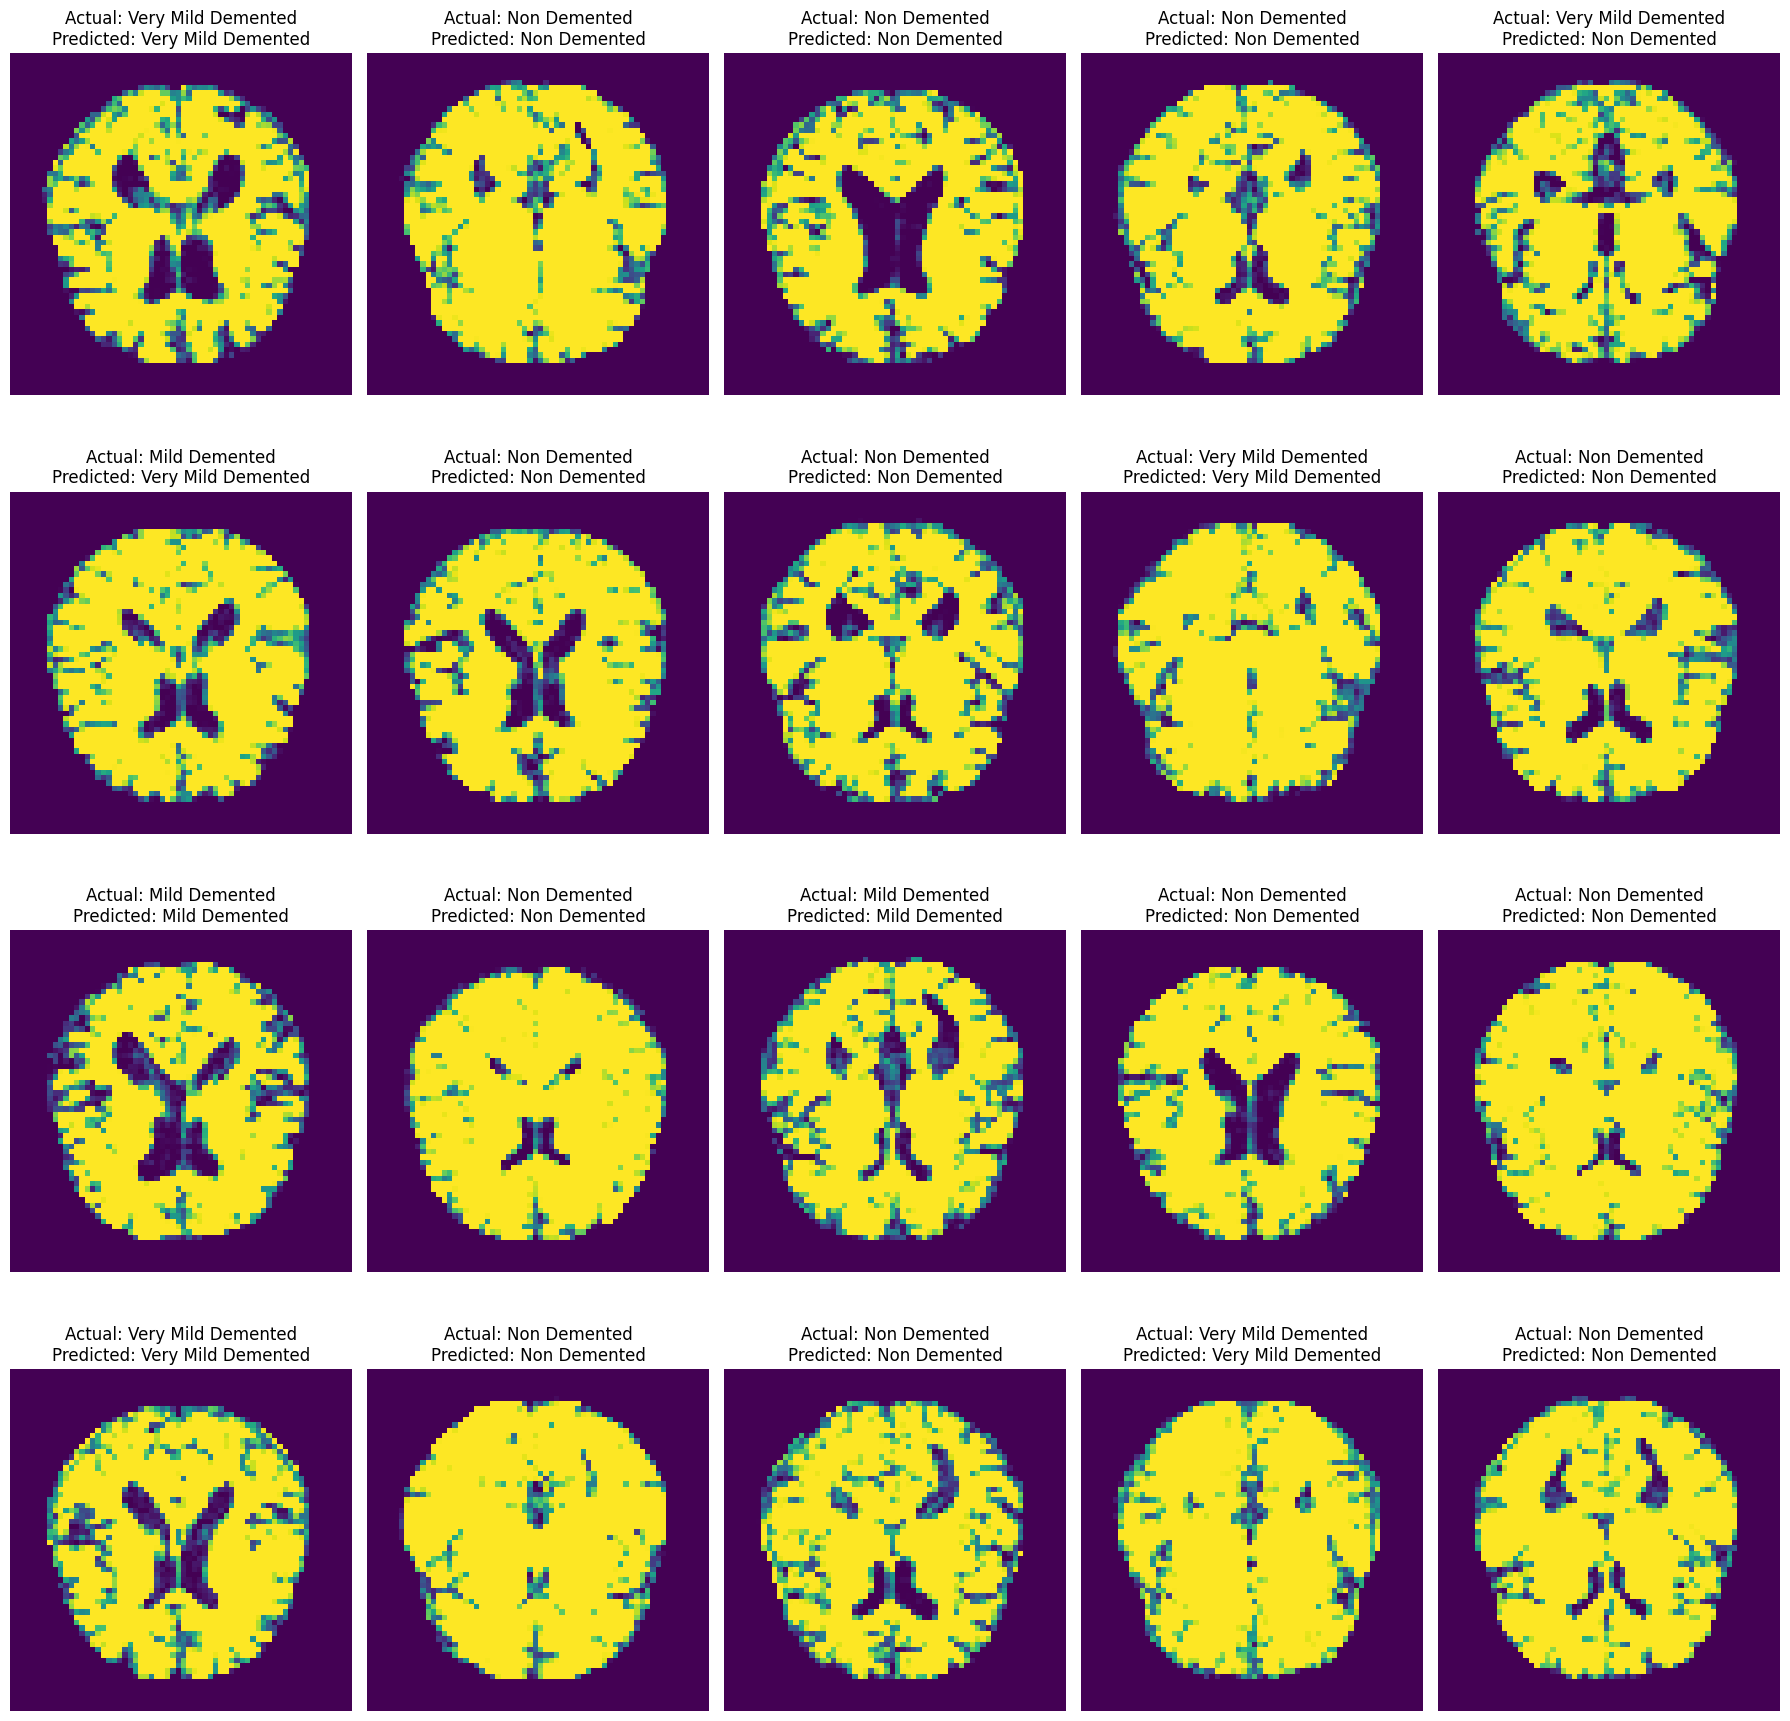

In [64]:
showPredictedOutputs(cnn2layer_dropout_best_epoch, cnn2layer_dropout_all_inputs, cnn2layer_dropout_predicted_outputs, cnn2layer_dropout_actual_outputs)

#### 3 Layers CNN without Dropout -- Predicted Output Samples

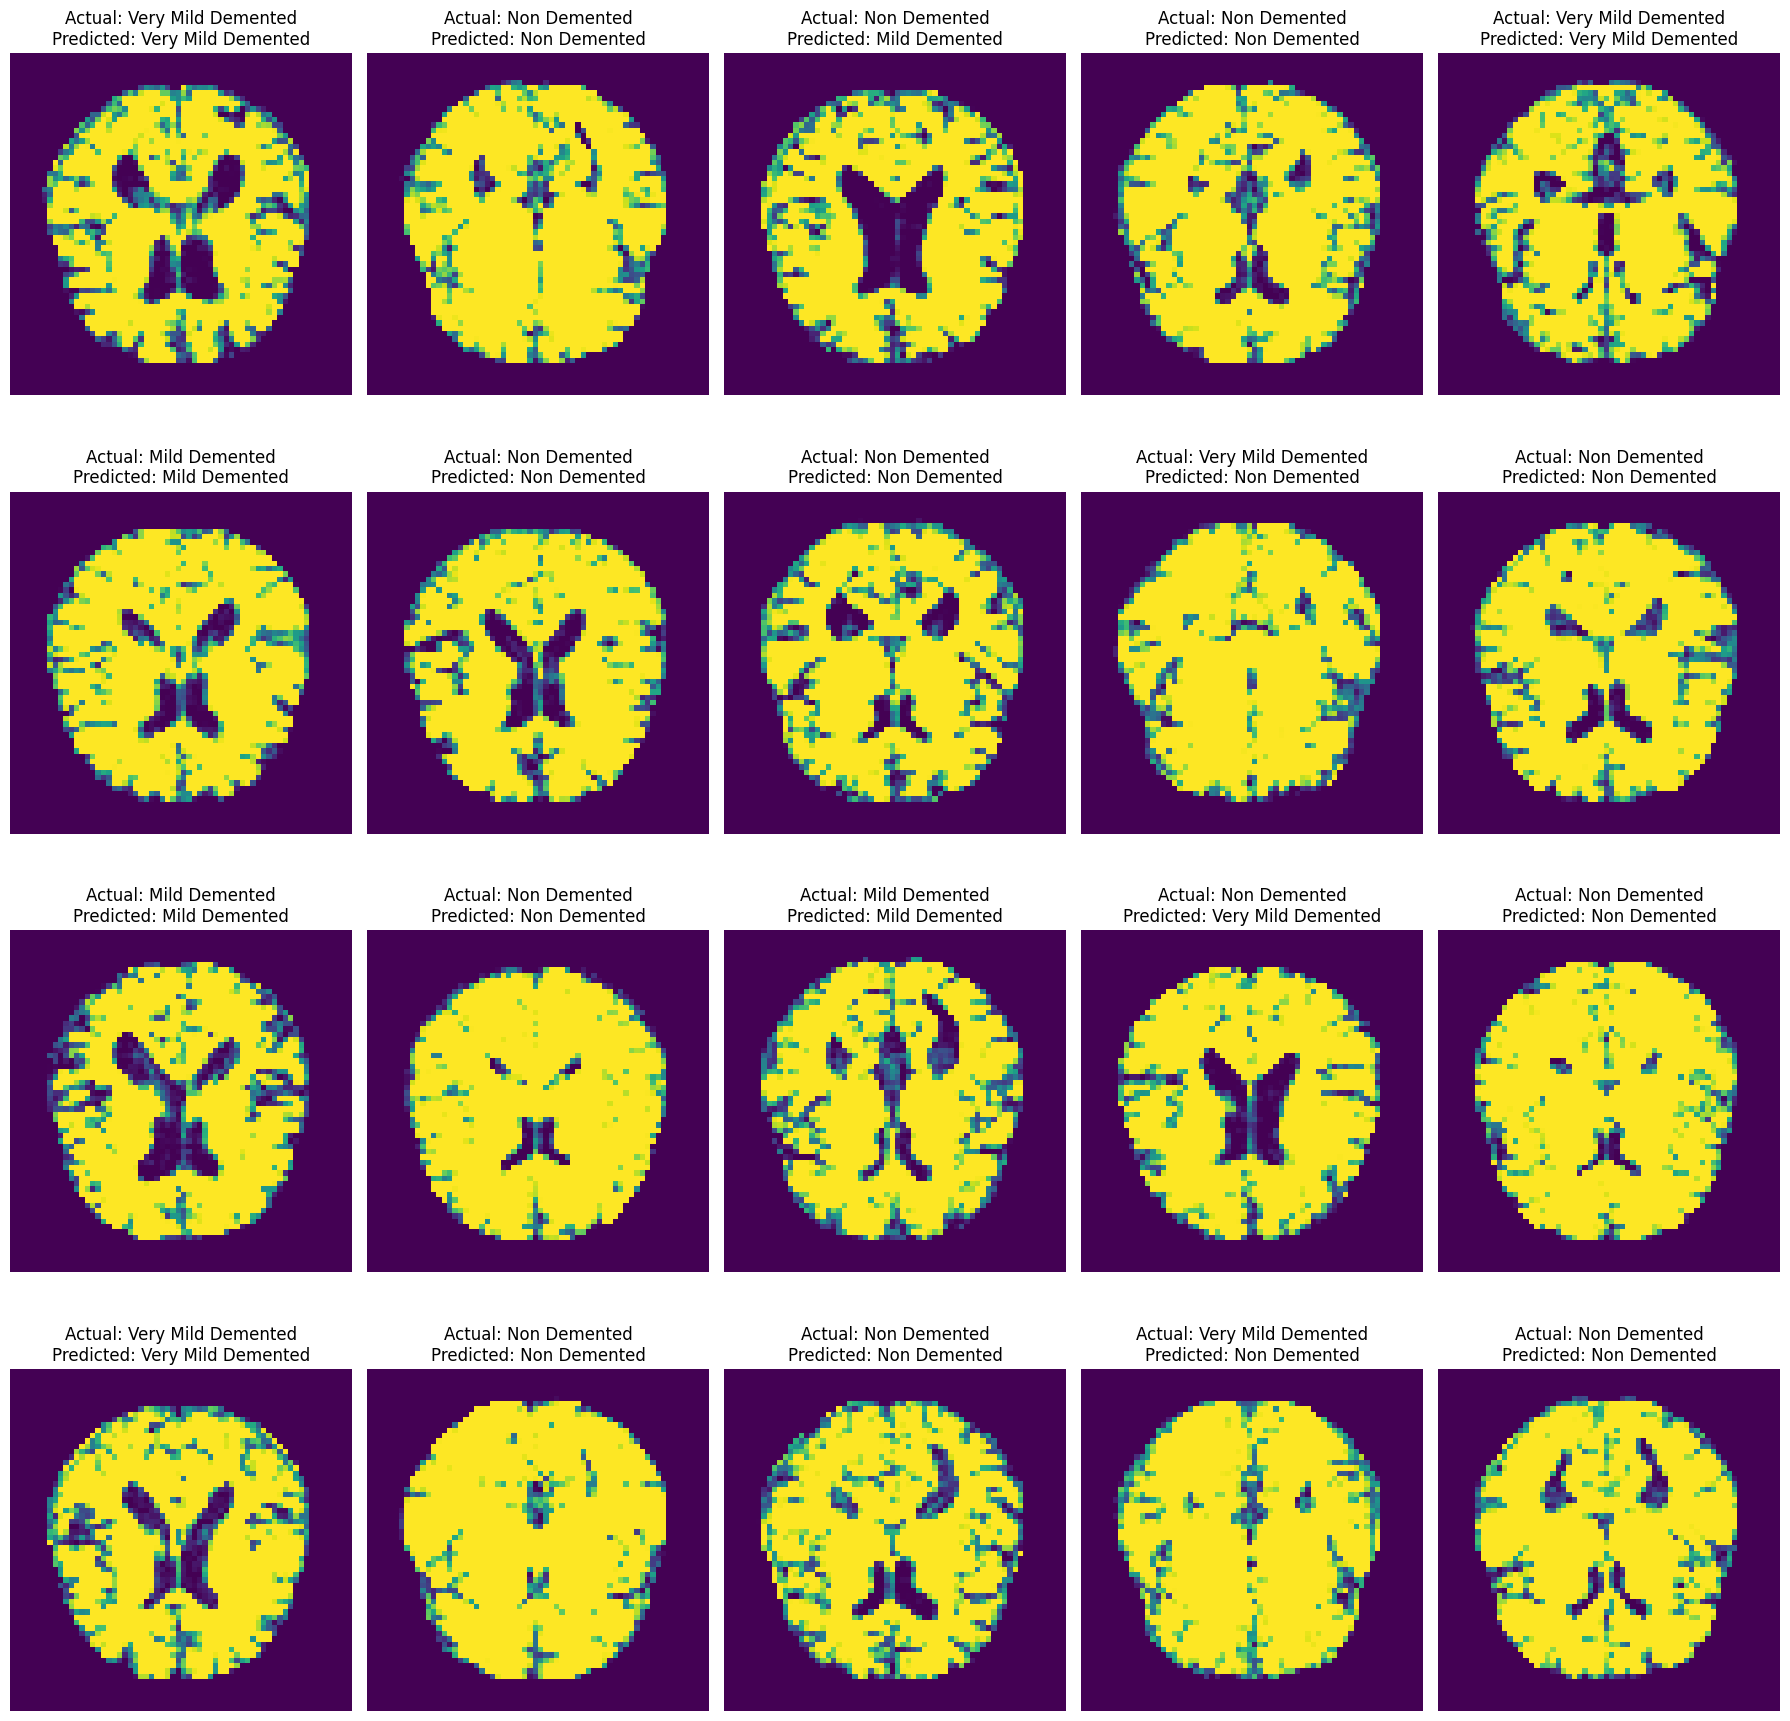

In [97]:
showPredictedOutputs(cnn3layer_best_epoch, cnn3layer_all_inputs, cnn3layer_predicted_outputs, cnn3layer_actual_outputs)

### 3 Layers CNN with Dropout -- Predicted Output Samples

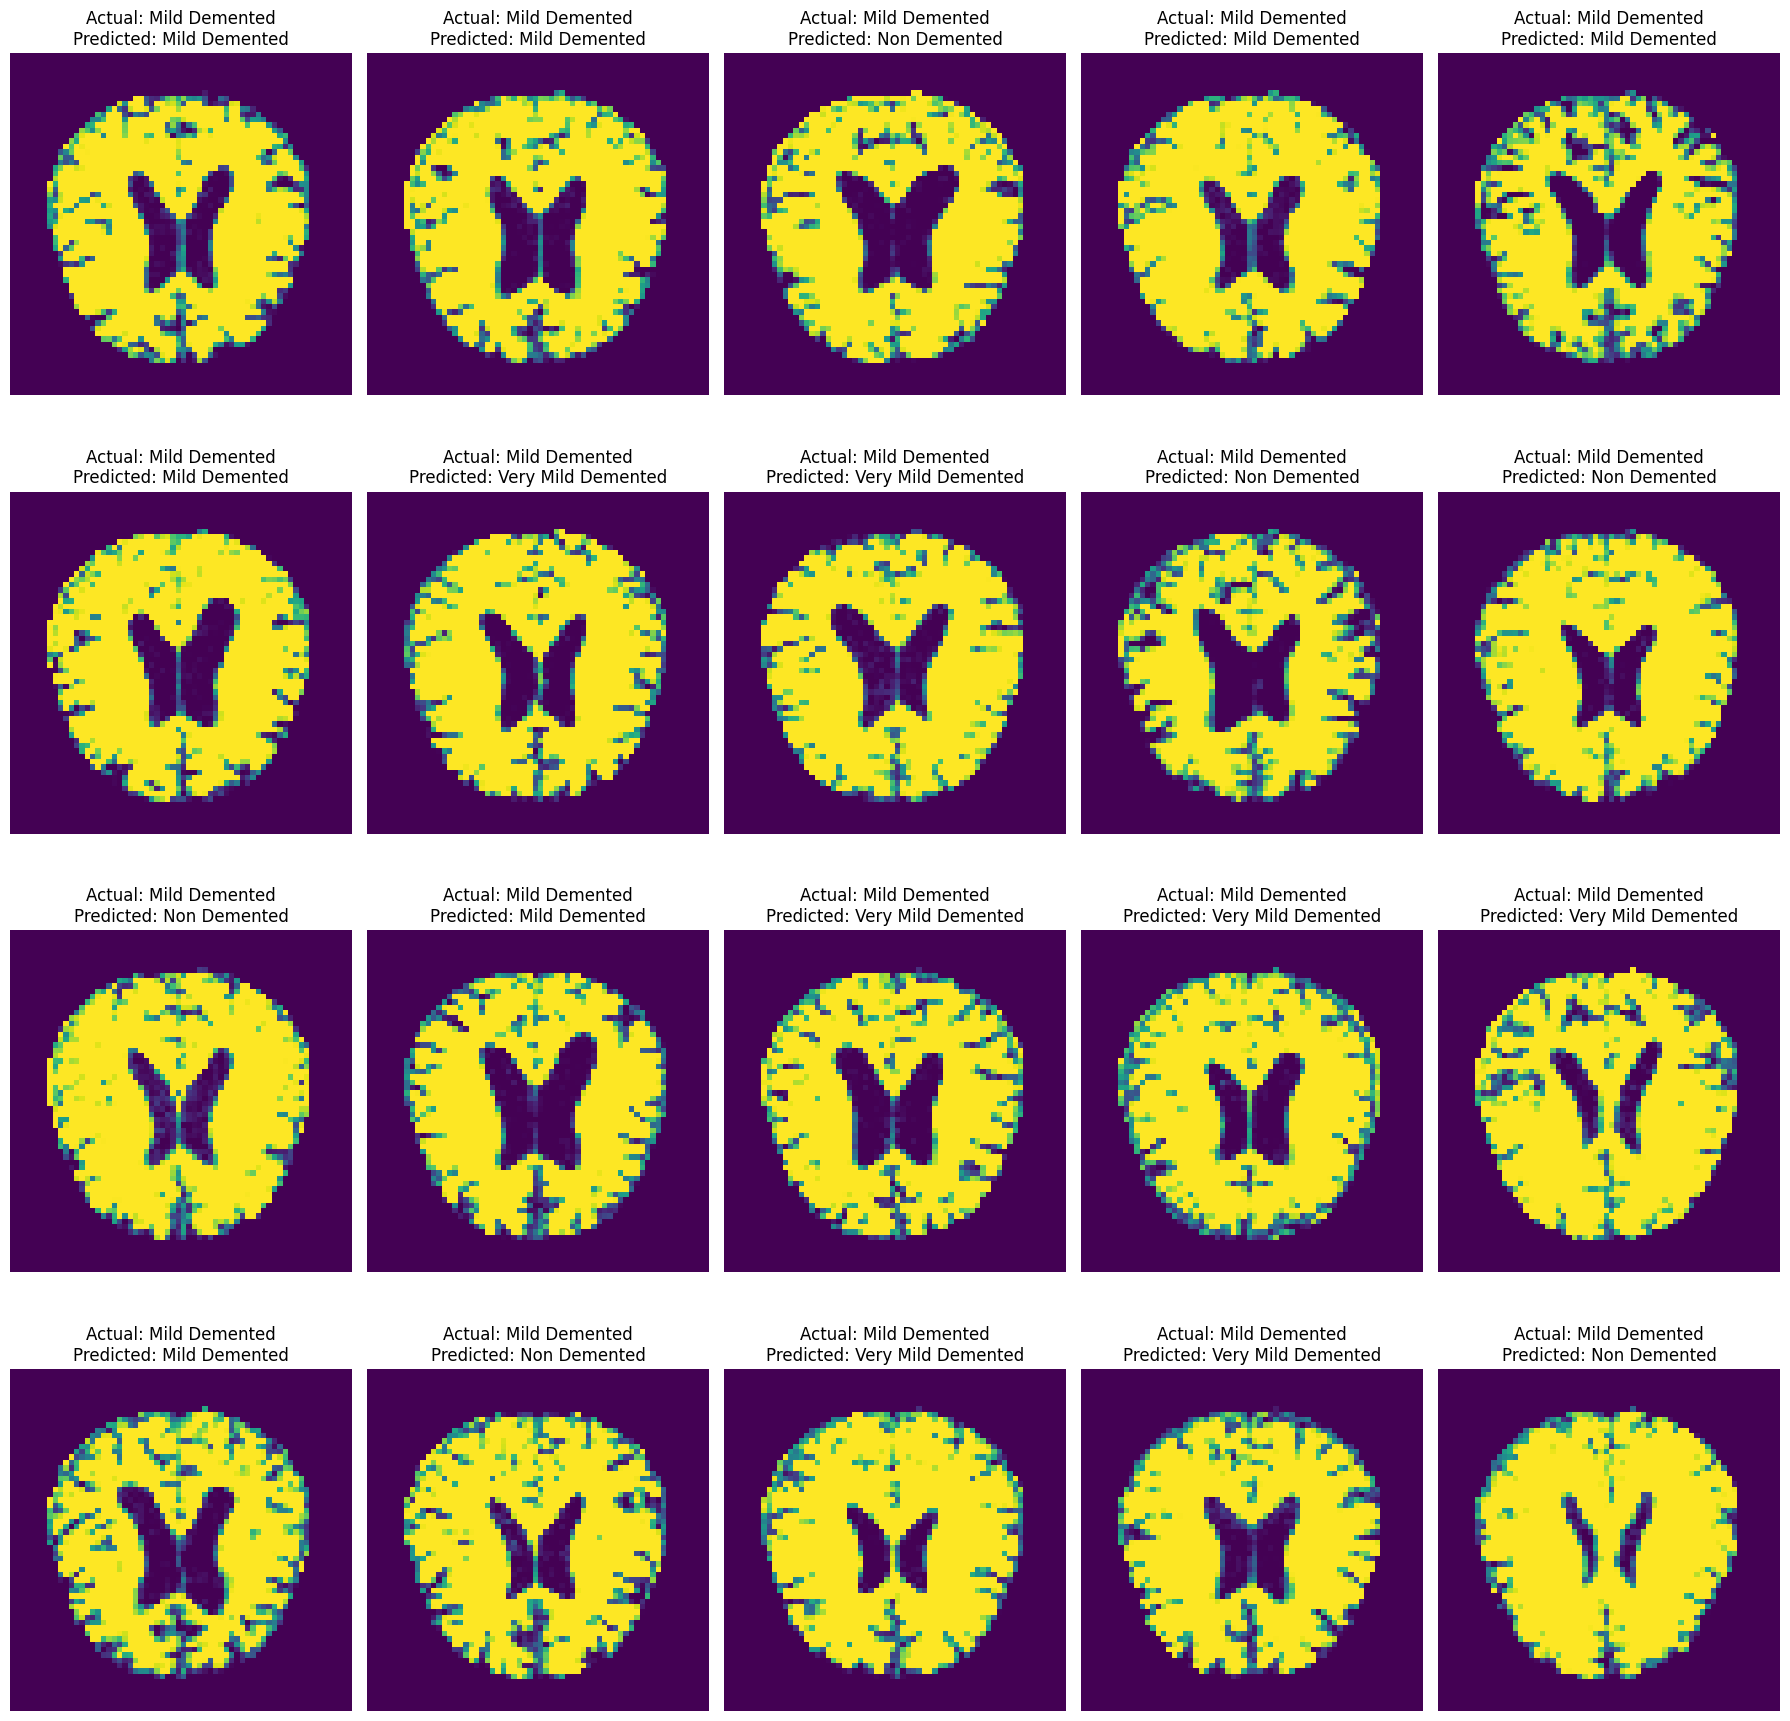

In [100]:
showPredictedOutputs(cnn3layer_dropout_best_epoch, cnn3layer_dropout_all_inputs, cnn3layer_dropout_predicted_outputs, cnn3layer_dropout_actual_outputs)

### VGG16 -- Predicted Output Samples

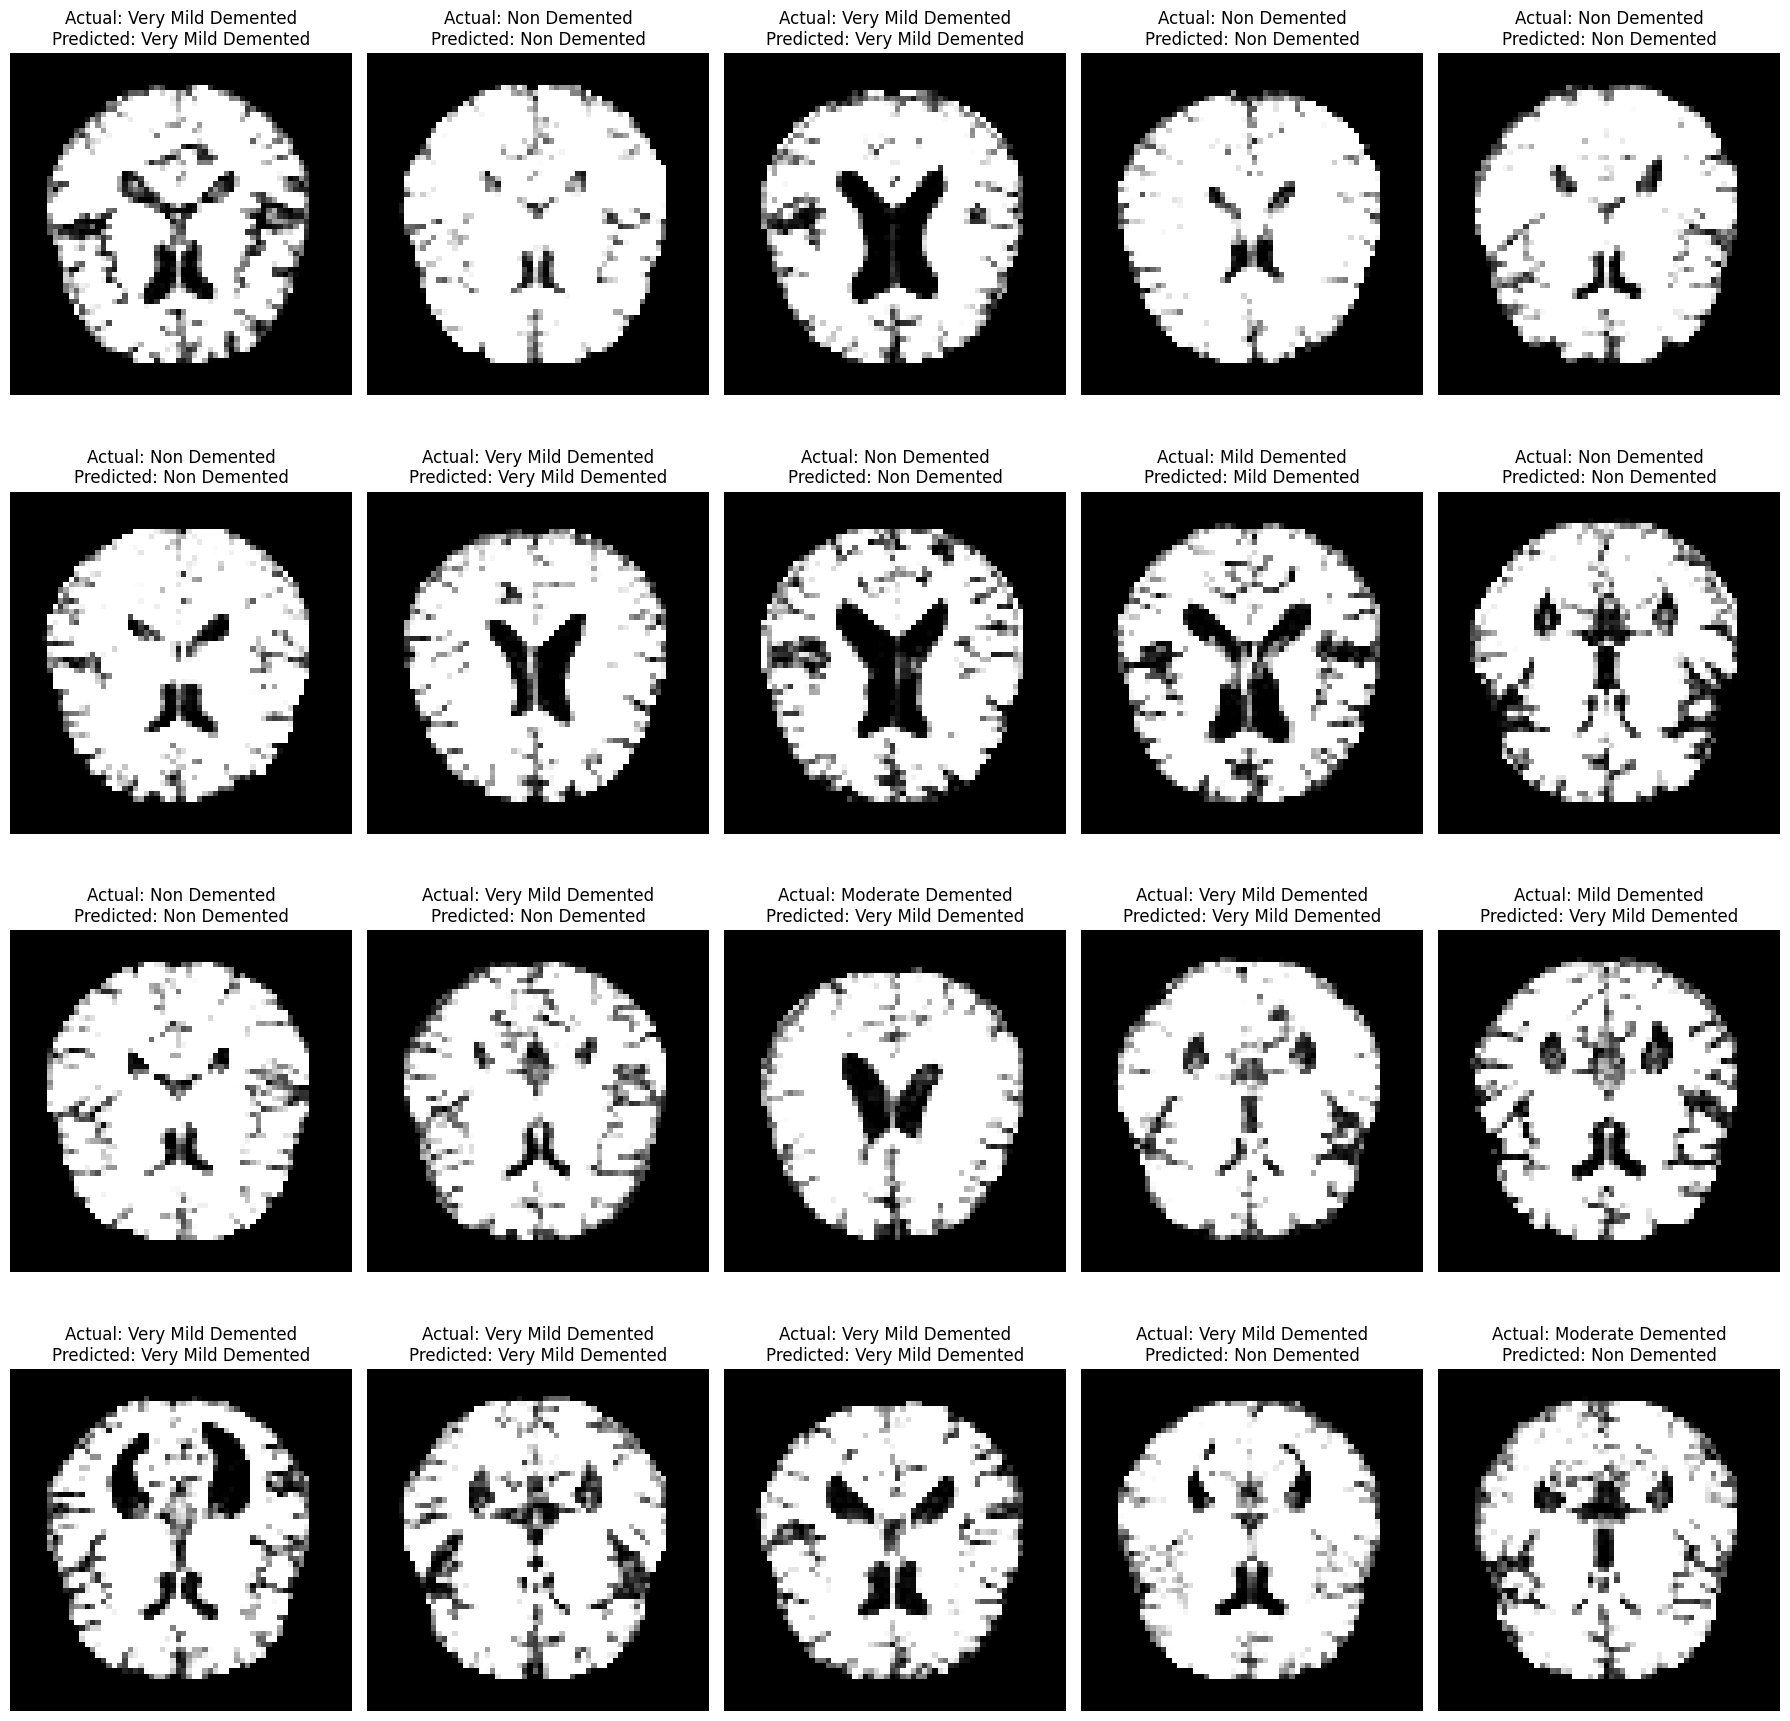

In [156]:
showPredictedOutputs(vgg16_best_epoch, vgg16_all_inputs, vgg16_predicted_outputs, vgg16_actual_outputs)

### Training Curves Plot -- Loss & Accuracy

In [65]:
# Utility functions for plotting results!
def plot_training_curves(training_curves, model_name, phases=['train', 'val', 'test'], metrics=['loss', 'acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.suptitle(model_name, fontweight='bold', fontsize=14, color='darkblue')
    for i, metric in enumerate(metrics):
        if metric == 'loss':
            y_label = 'Loss Values'
            title = 'Loss'
        elif metric == 'acc':
            y_label = 'Accuracy Values'
            title = 'Accuracy'
        else:
            y_label = metric
            title = metric
        axes[i].set_title(f'Training curve - {title}', fontweight='bold')
        training_curve_vals = []
        for phase in phases:
            key = phase + '_' + metric
            if key in training_curves:
                values = training_curves[key]
                if isinstance(values[0], torch.Tensor): # Check if the values are on GPU
                  if values[0].device.type == 'cuda':
                    values = [tensor.detach().cpu().numpy() for tensor in values]
                  else:
                    values = [tensor.numpy() for tensor in values]
                axes[i].plot(epochs, values)
            training_curve_vals.append(values)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(f'{y_label}')
        axes[i].legend(labels=phases)

#### 2 Layers CNN without Dropout -- Loss & Accuracy

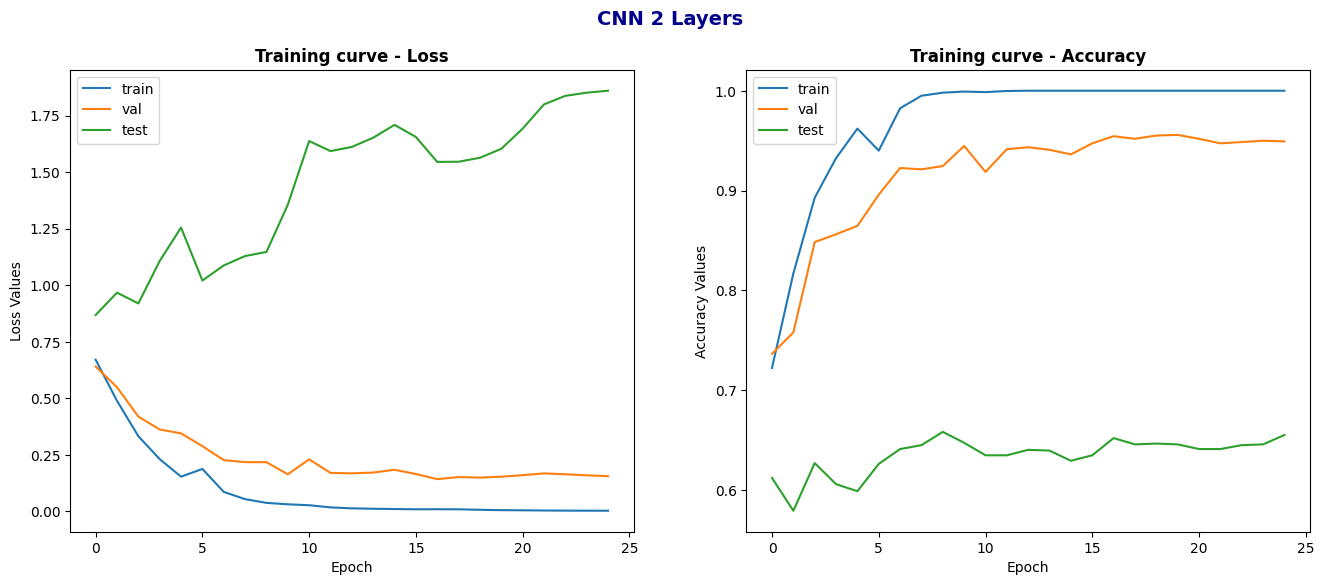

In [67]:
plot_training_curves(cnn2layer_training_curves, 'CNN 2 Layers')


#### 2 Layers CNN with Dropout -- Loss & Accuracy

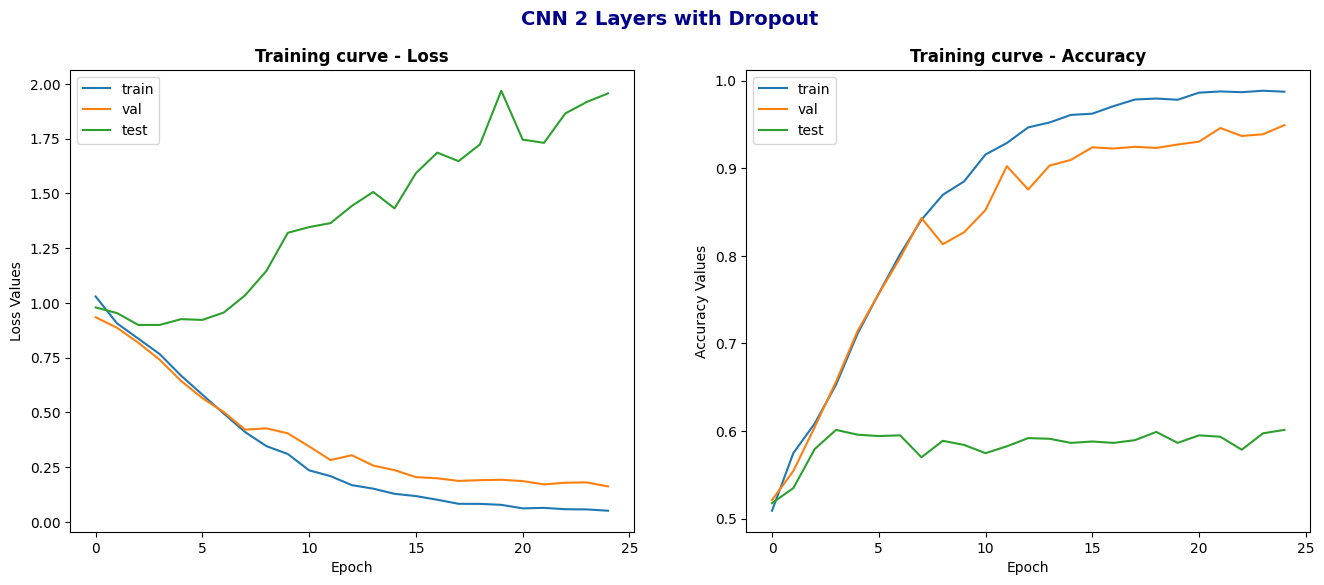

In [68]:
plot_training_curves(cnn2layer_dropout_training_curves, 'CNN 2 Layers with Dropout')


#### 3 Layers CNN without Dropout -- Loss & Accuracy

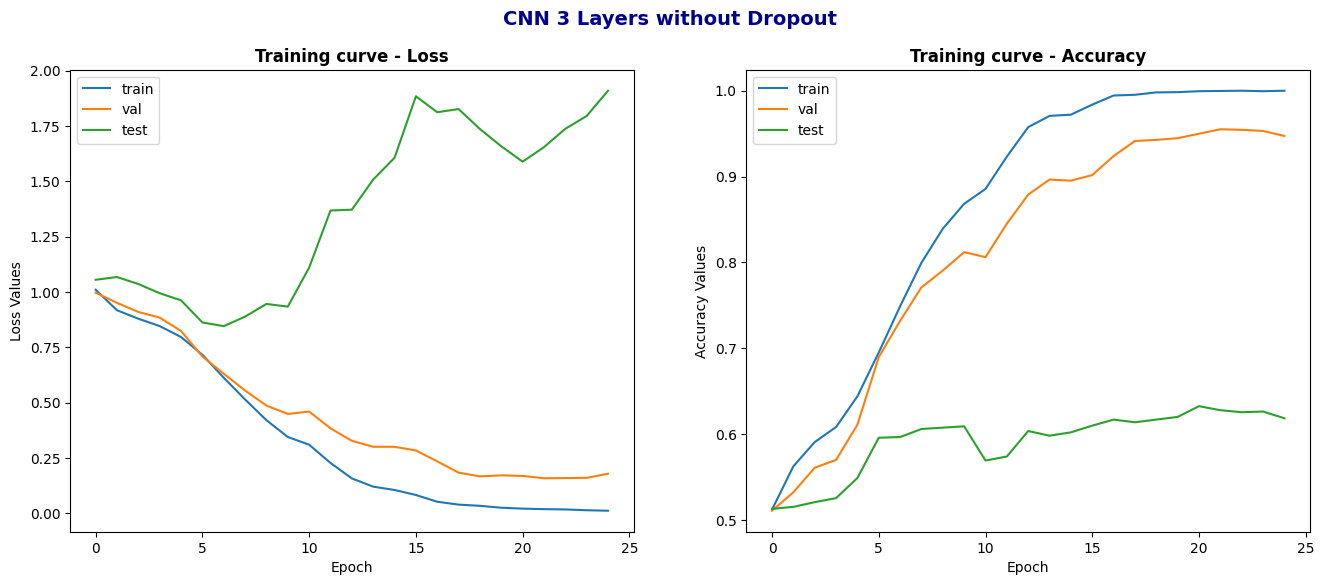

In [98]:
plot_training_curves(cnn3layer_training_curves, 'CNN 3 Layers without Dropout')


### 3 Layers CNN with Dropout -- Loss & Accuracy

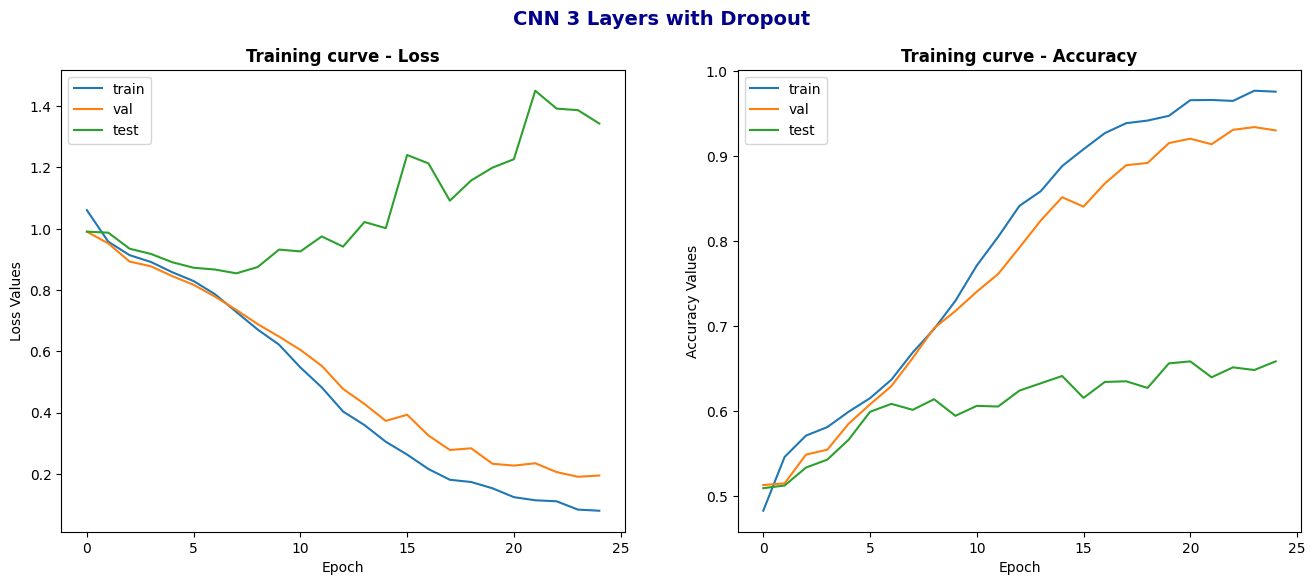

In [101]:
plot_training_curves(cnn3layer_dropout_training_curves, 'CNN 3 Layers with Dropout')


### VGG16 -- Loss & Accuracy

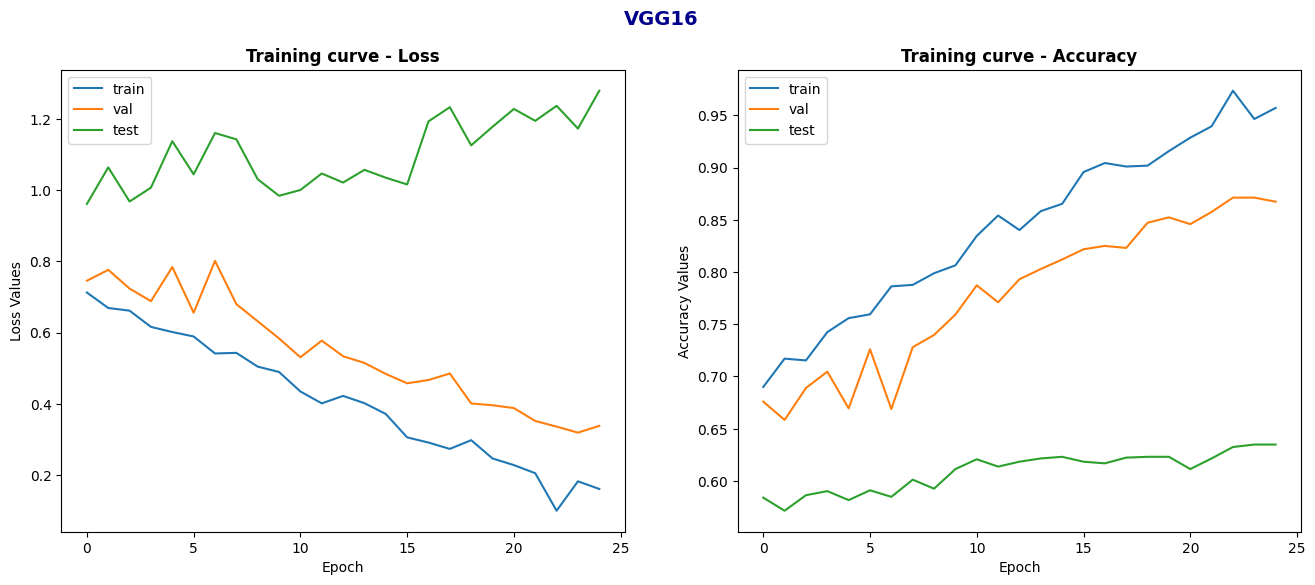

In [157]:
plot_training_curves(vgg16_training_curves, 'VGG16')

### Confusion Matrix

In [173]:
def classify_predictions(model, model_name, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([], dtype=torch.long, device=device)
    all_preds = torch.tensor([], dtype=torch.long, device=device)
    all_probs = torch.tensor([], dtype=torch.float, device=device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)

        if (model_name == 'VGG16'):
          inputs = inputs.repeat(1, 3, 1, 1)

        outputs = torch.softmax(model(inputs),dim=1)

        _, preds = torch.max(outputs, 1)
        # Calculate the predicted class probabilities using softmax
        probs = F.softmax(outputs, dim=1)
        all_labels = torch.cat((all_labels, labels), 0)
        all_preds = torch.cat((all_preds, preds), 0)
        all_probs = torch.cat((all_probs, probs), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_probs.detach().cpu()

def plot_cm(model, model_name, device, dataloaders, phase='test', metrics=['loss','acc']):
    class_labels = [classes[0], classes[1], classes[2], classes[3]]
    preds, labels, scores = classify_predictions(model, model_name, device, dataloaders[phase])
    plt.figure(figsize=(20, 12))
    cm = confusion_matrix(labels, preds)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f'Confusion Matrix - {model_name}', fontweight='bold', color='darkblue')
    plt.tight_layout()
    plt.show()

#### 2 Layers CNN without Dropout

<Figure size 2000x1200 with 0 Axes>

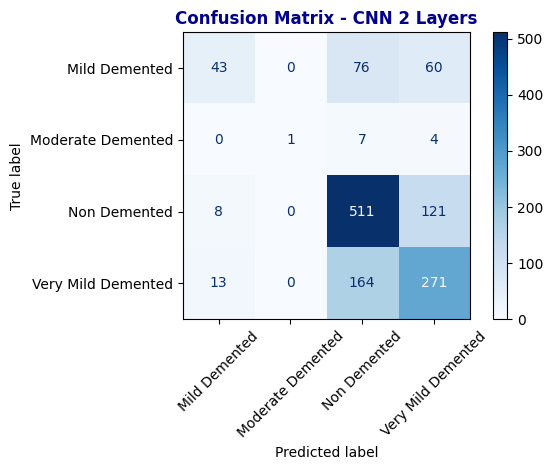

In [174]:
plot_cm(cnn2layer_model, 'CNN 2 Layers', device, dataloaders, phases[2])

#### CNN 2 Layers with Dropout

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Figure size 2000x1200 with 0 Axes>

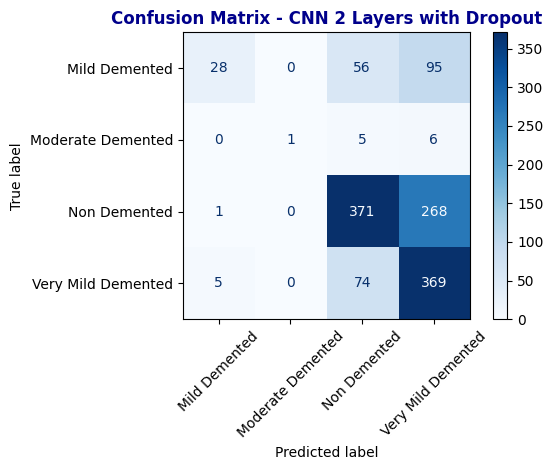

In [175]:
plot_cm(cnn2layer_dropout_model, 'CNN 2 Layers with Dropout', device, dataloaders, phases[2])

#### CNN 3 Layers

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Figure size 2000x1200 with 0 Axes>

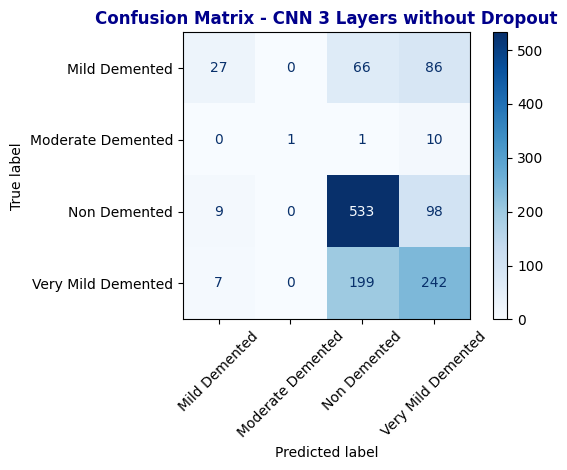

In [176]:
plot_cm(cnn3layer_model, 'CNN 3 Layers without Dropout', device, dataloaders, phases[2])

#### CNN 3 Layers with Dropout

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Figure size 2000x1200 with 0 Axes>

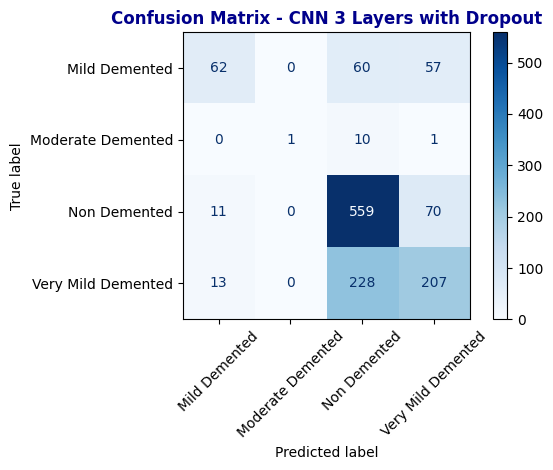

In [177]:
plot_cm(cnn3layer_dropout_model, 'CNN 3 Layers with Dropout', device, dataloaders, phases[2])

VGG16

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Figure size 2000x1200 with 0 Axes>

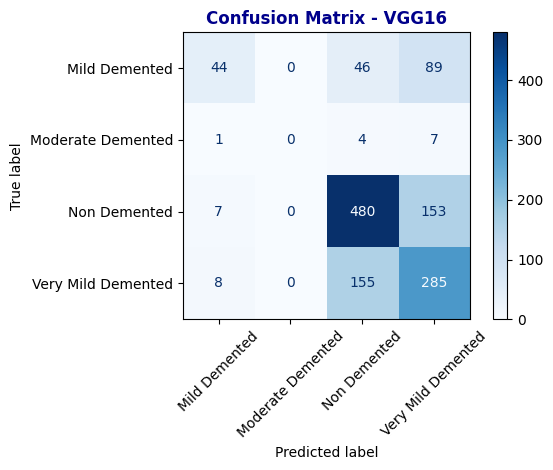

In [178]:
plot_cm(vgg16_model, 'VGG16', device, dataloaders, phases[2])

## Models Performance Comparison

### Validation Loss

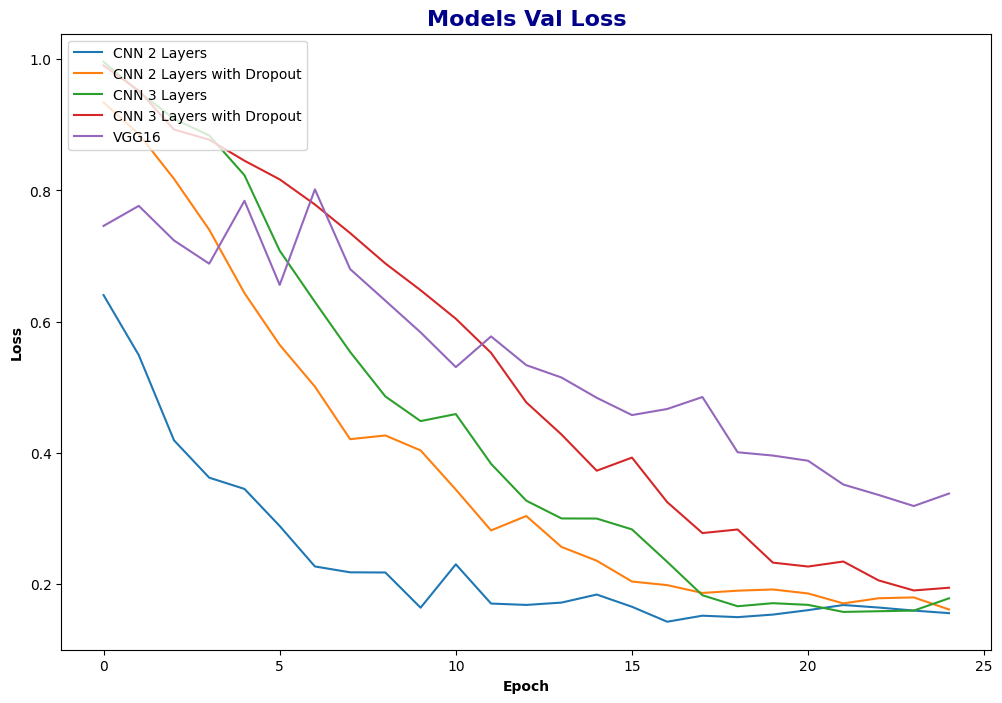

In [185]:
plt.figure(figsize=(12,8))
plt.plot(cnn2layer_training_curves['val_loss'])
plt.plot(cnn2layer_dropout_training_curves['val_loss'])
plt.plot(cnn3layer_training_curves['val_loss'])
plt.plot(cnn3layer_dropout_training_curves['val_loss'])
plt.plot(vgg16_training_curves['val_loss'])
plt.title("Models Val Loss", fontsize=16, fontweight='bold', color='darkblue')
plt.ylabel("Loss", fontweight='semibold')
plt.xlabel("Epoch", fontweight='semibold')
plt.legend(["CNN 2 Layers ","CNN 2 Layers with Dropout", "CNN 3 Layers", "CNN 3 Layers with Dropout", "VGG16"], loc='upper left')
plt.show()

### Validation Accuracy

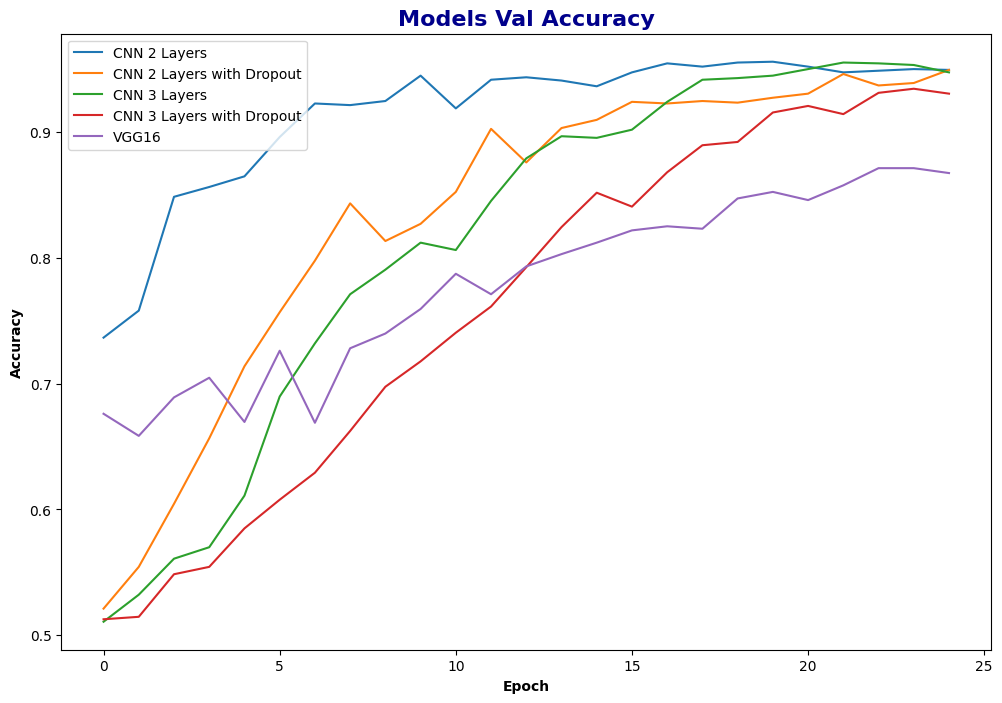

In [188]:
plt.figure(figsize=(12,8))
plt.plot(cnn2layer_training_curves['val_acc'])
plt.plot(cnn2layer_dropout_training_curves['val_acc'])
plt.plot(cnn3layer_training_curves['val_acc'])
plt.plot(cnn3layer_dropout_training_curves['val_acc'])
plt.plot(vgg16_training_curves['val_acc'])
plt.title("Models Val Accuracy", fontsize=16, fontweight='bold', color='darkblue')
plt.ylabel("Accuracy", fontweight='semibold')
plt.xlabel("Epoch", fontweight='semibold')
plt.legend(["CNN 2 Layers ","CNN 2 Layers with Dropout", "CNN 3 Layers", "CNN 3 Layers with Dropout", "VGG16"], loc='upper left')
plt.show()

## Conclusion

As per the above observations and performed experiments on models like 2 Layers CNN with and without Dropout layer, 3 Layers CNN with and without Dropout, and VGG16 model,

* We can see that basic 2 layers CNN performed better on augmented dataset of Alzheimers dataset with approximately 96% of accuracy on validation dataset.

* As per Training curves of Loss on models, we can see that all models showed some overfitting on data, as training loss was decrease when test or val loss was increasing. This could be due to classes imbalance in the data due to huge difference in number of images in different categories of Very Mild Demented, Mild Demented, Non Demented, and Moderate Demented.

* As per confusion matrix of all models, most number of classified true labels are of Non Demented. This can be due to presence of most number of images in Non Demented category which also justify the overfitting of models.